In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import json
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
from joblib import dump

# Save the preprocessor and the trained model

# Load the dataset
dataset_path = r"C:\Users\vivia\co-pilot-v1\data\processed_data\parts_data.feather" 
df = pd.read_feather(dataset_path)


# Exclude obsolete items and assign obsolescence_dummy
df = df[df['months_no_sale'] < 12].copy()
df['obsolescence_dummy'] = np.where(df['months_no_sale'] >= 6, 1, 0)

# Define features and target variable
drop_cols = ['part_number', 'description', 'supplier_name', 
            'sales_to_stock_ratio', 'reorder_point', 'sales_last_jan', 'sales_last_feb',
            'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
            'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
            'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
            'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
            'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
            'sales_revenue', 'cogs', 'cost_per_unit', 'rolling_12_month_sales',
            'price', 'safety_stock', 'months_no_sale']

X = df.drop(columns=drop_cols + ['obsolescence_dummy'])
y = df['obsolescence_dummy']
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define preprocessing for numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('scaler', RobustScaler()),
        ('power_trans', PowerTransformer(method='yeo-johnson'))]),
     numerical_features)])

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_rs, y_train_rs = smote.fit_resample(X_train_preprocessed, y_train)

X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Hyperparameter space for XGBoost
param_distributions = {
    'n_estimators': np.arange(200, 501, 100),
    'max_depth': list(np.arange(2, 10, 1)),  # Reduced upper limit
    'min_samples_split': np.arange(5, 25, 5),  # Increased the lower limit
    'min_samples_leaf': np.arange(5, 25, 5),  # Increased the lower limit
    'max_features': ['sqrt', 'log2'],  # Added a fixed fraction
    'bootstrap': [True]
}

# Randomized search setup
model = RandomForestClassifier(random_state=42)

rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=1000,  # You can adjust the number of iterations
    cv=5,  # Cross-validation setting
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_rs, y_train_rs)

# Best model from grid search
best_model = random_search.best_estimator_
print(best_model)
best_params = random_search.best_params_

selector = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(10), scoring='f1')
selector = selector.fit(X_train_rs, y_train_rs)

# Get the selected features
feature_names = X_train.columns.tolist()  # Get the feature names from your DataFrame
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.support_[i]]

# Transform training and test data to keep only selected features
X_train_selected = selector.transform(X_train_rs)
# Transform validation and test data to keep only selected features
X_val_selected = selector.transform(X_val_transformed)
X_test_selected = selector.transform(X_test_transformed)

# Re-train your classifier with the selected features
final_model = best_model.fit(X_train_selected, y_train_rs)

# Calibrate the model on the validation set using the selected features
calibrator = CalibratedClassifierCV(final_model, cv='prefit', method='sigmoid')
calibrated_model = calibrator.fit(X_val_selected.astype(np.float64), y_val.astype(np.float64))
# Predict probabilities on the test set using the selected features
y_test_proba = calibrated_model.predict_proba(X_test_selected)[:, 1].astype(np.float64)

calibrator_ = CalibratedClassifierCV(final_model, cv='prefit', method='isotonic')
calibrated_model_ = calibrator_.fit(X_val_selected.astype(np.float64), y_val.astype(np.float64))

preprocessor_path = r"C:\Users\vivia\co-pilot-v1\Dashboard\Models\obsolecence_predictor\preprocessor.joblib"
model_path = r"C:\Users\vivia\co-pilot-v1\Dashboard\Models\obsolecence_predictor\calibrated_best_random_forest_model.joblib"
dump(preprocessor, preprocessor_path)
dump(calibrated_model, model_path)

best_params_and_features = {
    'selected_features': selected_features,
    'best_hyperparameters': {k: (int(v) if isinstance(v, (np.int64, np.bool_)) else float(v) if isinstance(v, np.float64) else v) for k, v in best_params.items()}
}

# Serialize and save to JSON file
output_path = r'C:\Users\vivia\co-pilot-v1\Dashboard\Models\obsolecence_predictor\general_model_details.json'
with open(output_path, 'w') as file:
    json.dump(best_params_and_features, file, indent=4)


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=300;

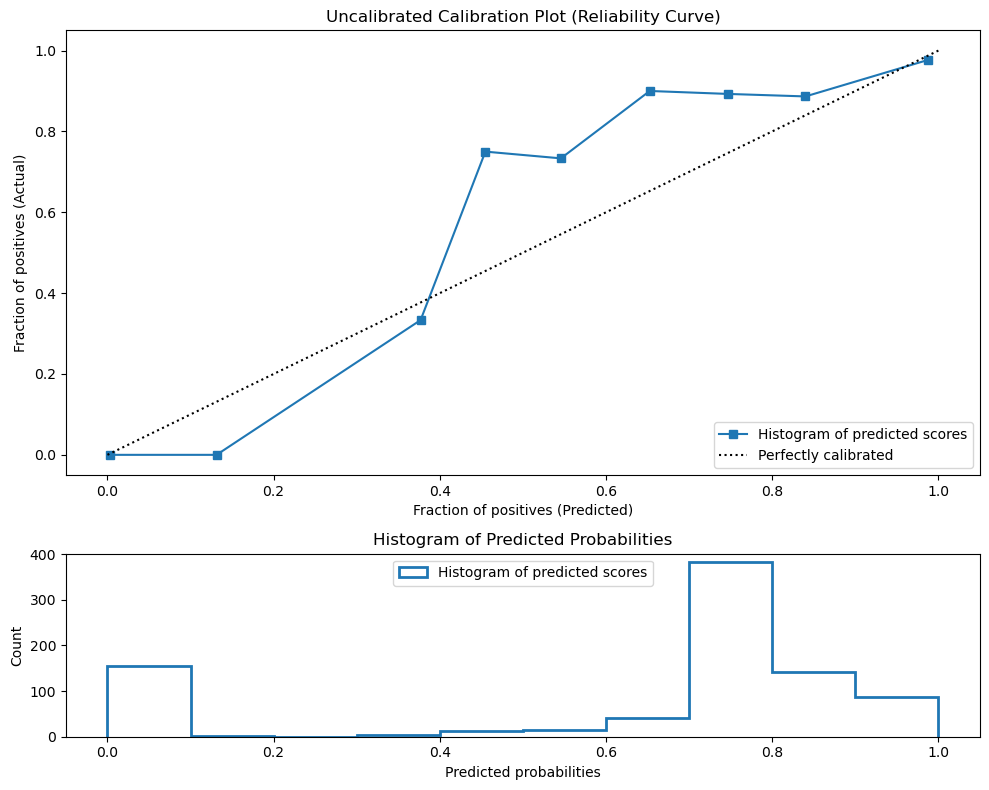

,auc,precision,recall,f1
0,0.870766,0.899096,0.983526,0.939418


In [3]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def compute_scores(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    precision = precision_score(y, estimator.predict(X))
    recall = recall_score(y, estimator.predict(X))
    f1 = f1_score(y, estimator.predict(X))
    return {'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1}

def plot_calibration_curve(estimator, X, y):

    proba = estimator.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, proba, n_bins=10)

    metric_dict = compute_scores(estimator, X, y)

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot(prob_pred, prob_true, 's-', label='Histogram of predicted scores')
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')
    ax1.set_title('Uncalibrated Calibration Plot (Reliability Curve)')

    ax2.hist(proba, range=(0, 1), bins=10, histtype='step', lw=2, label='Histogram of predicted scores')
    ax2.set_xlabel('Predicted probabilities')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper center', ncol=2)
    ax2.set_title('Histogram of Predicted Probabilities')

    plt.tight_layout()
    plt.show()

    df_metrics = pd.DataFrame([metric_dict])
    return df_metrics


compute_scores(final_model, X_test_selected, y_test)
plot_calibration_curve(final_model, X_test_selected, y_test)

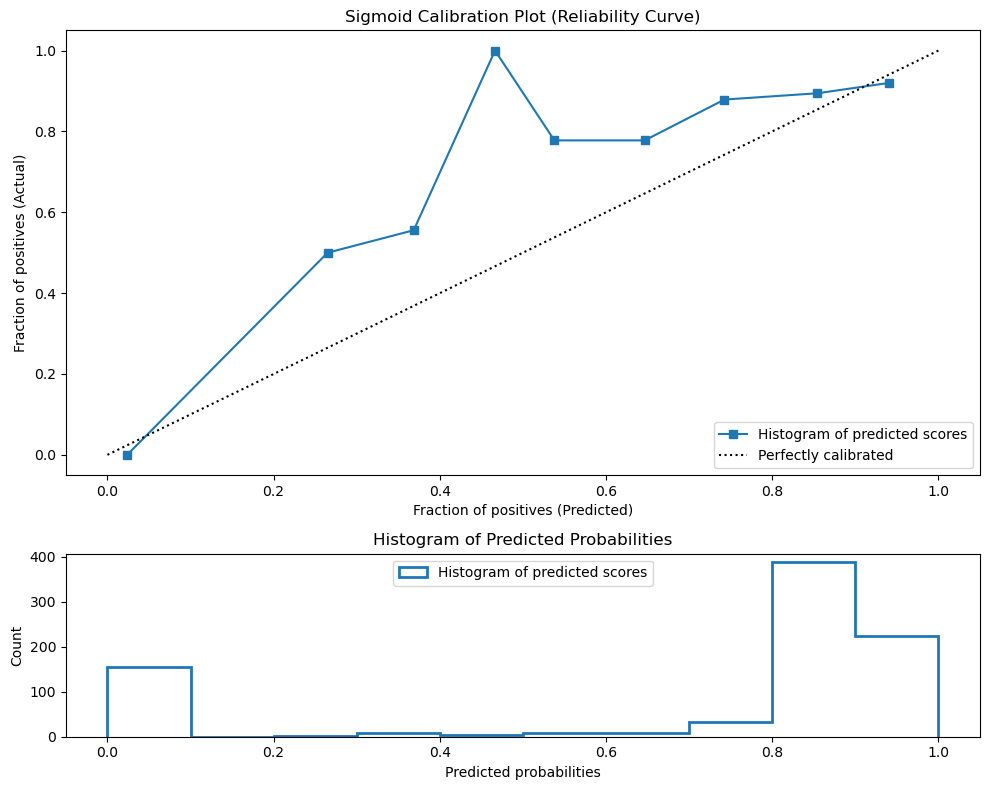

,auc,precision,recall,f1
0,0.870766,0.899096,0.983526,0.939418


In [4]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def compute_scores(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    precision = precision_score(y, estimator.predict(X))
    recall = recall_score(y, estimator.predict(X))
    f1 = f1_score(y, estimator.predict(X))
    return {'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1}

def plot_calibration_curve(estimator, X, y):

    proba = estimator.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, proba, n_bins=10)

    metric_dict = compute_scores(estimator, X, y)

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot(prob_pred, prob_true, 's-', label='Histogram of predicted scores')
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')
    ax1.set_title('Sigmoid Calibration Plot (Reliability Curve)')

    ax2.hist(proba, range=(0, 1), bins=10, histtype='step', lw=2, label='Histogram of predicted scores')
    ax2.set_xlabel('Predicted probabilities')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper center', ncol=2)
    ax2.set_title('Histogram of Predicted Probabilities')

    plt.tight_layout()
    plt.show()

    df_metrics = pd.DataFrame([metric_dict])
    return df_metrics


compute_scores(calibrated_model, X_test_selected, y_test)
plot_calibration_curve(calibrated_model, X_test_selected, y_test)

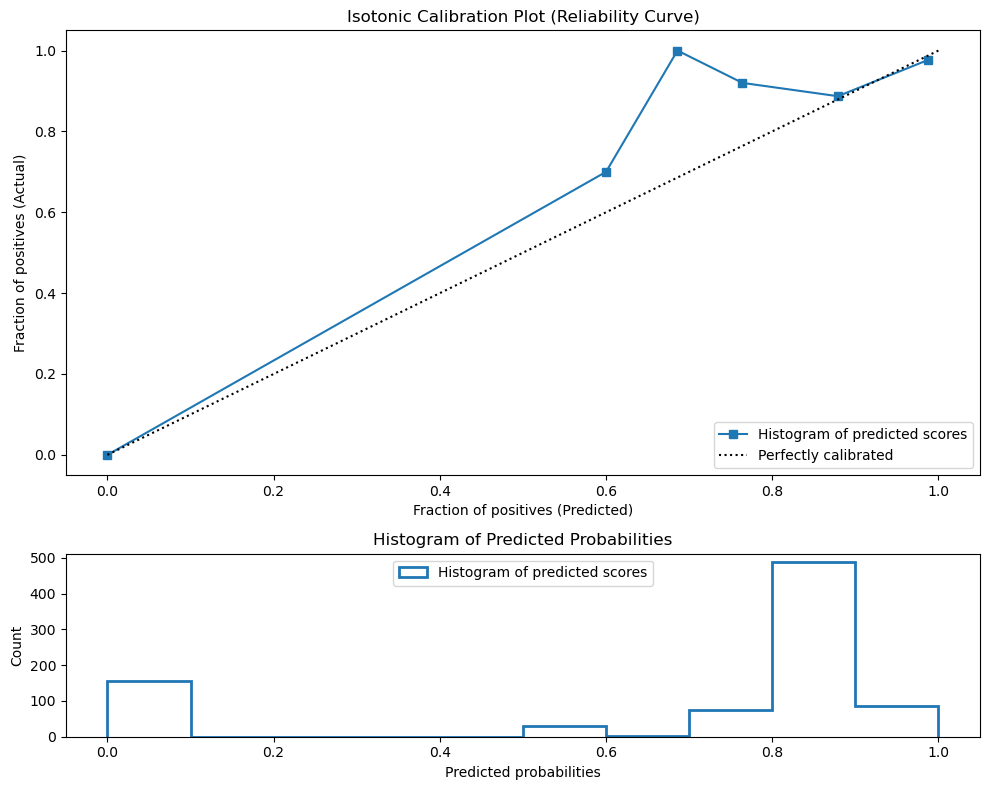

,auc,precision,recall,f1
0,0.86696,0.893962,1.0,0.944012


In [5]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

def compute_scores(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    precision = precision_score(y, estimator.predict(X))
    recall = recall_score(y, estimator.predict(X))
    f1 = f1_score(y, estimator.predict(X))
    return {'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1}

def plot_calibration_curve(estimator, X, y):

    proba = estimator.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, proba, n_bins=10)

    metric_dict = compute_scores(estimator, X, y)

    plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot(prob_pred, prob_true, 's-', label='Histogram of predicted scores')
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')
    ax1.set_title('Isotonic Calibration Plot (Reliability Curve)')

    ax2.hist(proba, range=(0, 1), bins=10, histtype='step', lw=2, label='Histogram of predicted scores')
    ax2.set_xlabel('Predicted probabilities')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper center', ncol=2)
    ax2.set_title('Histogram of Predicted Probabilities')

    plt.tight_layout()
    plt.show()

    df_metrics = pd.DataFrame([metric_dict])
    return df_metrics


compute_scores(calibrated_model_, X_test_selected, y_test)
plot_calibration_curve(calibrated_model_, X_test_selected, y_test)

                   Feature  Importance
0    rolling_3_month_sales    0.604462
2  three_month_days_supply    0.143274
1             gross_profit    0.097036
3     three_month_turnover    0.077850
4       seasonal_component    0.077378


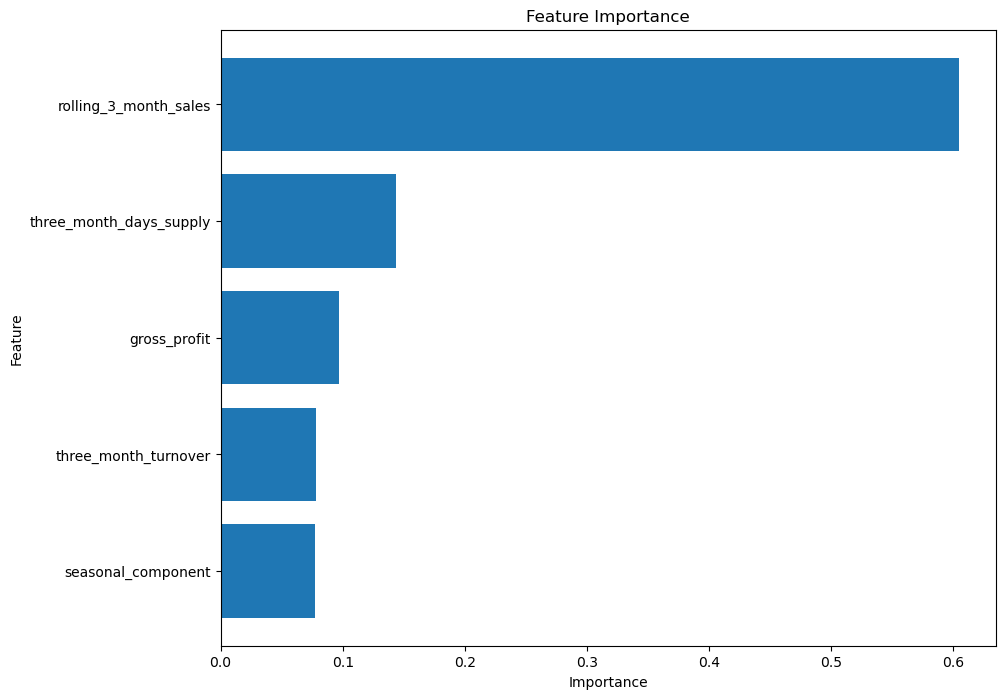

In [6]:
feature_importances = best_model.feature_importances_

# Create a pandas DataFrame to display feature importances
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.support_[i]]

# Now create the DataFrame with these selected features
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame to show the most important features at the top
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importance DataFrame
print(feature_importance_df)

import matplotlib.pyplot as plt

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To show the highest importance at the top
plt.show()

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# is this separate data? used the same one for now
# "/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_finalized.feather"
df = pd.read_feather(dataset_path)

print(df.columns)

# Exclude obsolete items and assign obsolescence_dummy
df = df[df['inventory_category'] != 'obsolete'].copy()
df['obsolescence_dummy'] = np.where(df['months_no_sale'] > 6, 1, 0)

# Define features and target variable
drop_cols = ['part_number', 'description', 'supplier_name', 'inventory_category', 
             'last_sold_date', 'last_received_date', 'sales_to_stock_ratio', 'reorder_point',
             'months_no_sale', 'sales_revenue', 'price', 'seasonal_component', 'cogs',
             'rolling_12_month_sales', 'obsolescence_risk', 'margin']
X = df.drop(columns=drop_cols + ['obsolescence_dummy'])

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your features DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

Index(['part_number', 'description', 'supplier_name', 'quantity', 'price',
       'margin', 'months_no_sale', 'last_sold_date', 'quantity_ordered_ytd',
       'last_received_date', 'special_orders_ytd', 'negative_on_hand',
       'rolling_12_month_sales', 'rolling_3_month_sales', 'cost_per_unit',
       'total_cost', 'sales_revenue', 'cogs', 'margin_percentage',
       'gross_profit', 'roi', '365_days_supply', '90_days_supply',
       '12_month_turnover', '90_day_turnover', 'sales_to_stock_ratio',
       'order_to_sales_ratio', 'seasonal_component', 'demand',
       'inventory_category', 'safety_stock', 'reorder_point',
       'obsolescence_risk'],
      dtype='object')
                  feature       VIF
0                quantity  2.523354
1    quantity_ordered_ytd  1.446477
2      special_orders_ytd  1.174265
3        negative_on_hand  1.034587
4   rolling_3_month_sales  1.845923
5           cost_per_unit  2.079069
6              total_cost  2.801014
7       margin_percentage  4.0139

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_feather(dataset_path)
df.columns

Index(['part_number', 'description', 'supplier_name', 'quantity', 'price',
       'margin', 'months_no_sale', 'quantity_ordered_ytd',
       'special_orders_ytd', 'sales_last_jan', 'sales_last_feb',
       'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
       'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
       'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
       'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
       'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
       'negative_on_hand', 'rolling_12_month_sales', 'rolling_3_month_sales',
       'cost_per_unit', 'total_cost', 'sales_revenue', 'cogs',
       'margin_percentage', 'gross_profit', 'roi', 'annual_days_supply',
       'three_month_days_supply', 'one_month_days_supply',
       'annual_month_turnover', 'three_month_turnover', 'one_month_turnover',
       'sales_to_stock_ratio', 'order_to_sales_ratio', 'seasonal_component',
  

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name', 
            'sales_to_stock_ratio', 'reorder_point', 'sales_last_jan', 'sales_last_feb',
            'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
            'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
            'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
            'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
            'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
            'sales_revenue', 'cogs', 'cost_per_unit', 'rolling_12_month_sales',
            'price', 'safety_stock'}]

X = df[feature_cols]

# Add a constant to the DataFrame
df = sm.add_constant(X)

# Replace inf values with NaNs and then drop rows with NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display the VIF for each feature
print(vif_data)

                    feature        VIF
0                     const  11.698100
1                  quantity   2.427751
2                    margin   1.309602
3            months_no_sale   1.265673
4      quantity_ordered_ytd   1.420481
5        special_orders_ytd   1.035556
6          negative_on_hand   1.038481
7     rolling_3_month_sales   3.821188
8                total_cost   1.443081
9         margin_percentage   1.114913
10             gross_profit   2.197055
11                      roi   1.013377
12       annual_days_supply   1.756772
13  three_month_days_supply   1.435525
14    one_month_days_supply   1.262273
15    annual_month_turnover   1.591960
16     three_month_turnover   1.626840
17       one_month_turnover   1.104037
18     order_to_sales_ratio   1.379532
19       seasonal_component   3.568410
20                   demand   1.995023


In [4]:
df = pd.read_feather(dataset_path)
df.columns

Index(['part_number', 'description', 'supplier_name', 'quantity', 'price',
       'margin', 'months_no_sale', 'quantity_ordered_ytd',
       'special_orders_ytd', 'sales_last_jan', 'sales_last_feb',
       'sales_last_mar', 'sales_last_apr', 'sales_last_may', 'sales_last_jun',
       'sales_last_jul', 'sales_last_aug', 'sales_last_sep', 'sales_last_oct',
       'sales_last_nov', 'sales_last_dec', 'sales_jan', 'sales_feb',
       'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 'sales_jul',
       'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 'sales_dec',
       'negative_on_hand', 'rolling_12_month_sales', 'rolling_3_month_sales',
       'cost_per_unit', 'total_cost', 'sales_revenue', 'cogs',
       'margin_percentage', 'gross_profit', 'roi', 'annual_days_supply',
       'three_month_days_supply', 'one_month_days_supply',
       'annual_month_turnover', 'three_month_turnover', 'one_month_turnover',
       'sales_to_stock_ratio', 'order_to_sales_ratio', 'seasonal_component',
  